In [134]:
import numpy as np
import matplotlib.pyplot as plt
import random
import os

try:
    from dtw import dtw
except:
    !pip install dtw
    from dtw import dtw


In [135]:
# Le dossier de sauvegarde DRIVE
from google.colab import drive,files
drive.mount('/content/gdrive')
!ls /content


DRUMKIT_LEDOSSIER = "/content/gdrive/Shareddrives/# Zone de Code #/Classer Drumkit/data/Material ~ Drum Kit (DrumDigger)"

print(os.listdir(DRUMKIT_LEDOSSIER))

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
gdrive	sample_data
["Fx's & Vox", "808's", 'Claps', 'Cymbals', 'Extra #', 'Hats', 'Kicks', "Vox's #", 'Snares', 'Percs', 'Loops']


In [136]:
bayAranger_DRUMKIT_LEDOSSIER = DRUMKIT_LEDOSSIER + '/Hats'

listeFichiersAUDIO_0 = np.array([fic for fic in os.listdir(bayAranger_DRUMKIT_LEDOSSIER) if fic.split(".")[-1] in ["mp3", "wav"]  ])
listeFichiersAUDIO = [bayAranger_DRUMKIT_LEDOSSIER + "/" + fic for fic in os.listdir(bayAranger_DRUMKIT_LEDOSSIER) if fic.split(".")[-1] in ["mp3", "wav"]  ]
print(listeFichiersAUDIO_0)

['SM_HAT (8).wav' 'hat 4.wav' '09 hat.wav' 'HAT (16).wav'
 'codeine hat (2).wav' '[HAT] - 08.wav' '[HAT] - 06.wav'
 '[HAT] - 06 (2).wav' '[HAT] - 07.wav' '[HAT] - 02.wav' 'ZHAT05.wav'
 'VIOLENT HAT (2).wav' 'VIOLENT HAT (4).wav' 'ZHAT02.wav'
 'VIOLENT HAT (3).wav' 'ZHAT04.wav' 'ZHAT01.wav' 'VIOLENT HAT (9).wav'
 'SM_HAT (9).wav' 'hat 01.wav' 'HAT 06.wav' 'HAT 10.wav' 'HAT 02.wav'
 'Hat 0014.wav' 'Hat 0006.wav' 'Hat 0005.wav' 'Hat 0003.wav'
 'Hat 0001 (2).wav' 'HAT (18).wav' 'HAT (6).wav' 'HAT (4).wav'
 'Hat 0001.wav' 'HAT (17).wav' 'codeine hat (17).wav' 'A21_HAT_08.wav'
 'codeine hat (16).wav' 'codeine hat (15).wav' 'A21_HAT_11.wav'
 'A21_HAT_25.wav' 'codeine hat (10).wav' 'A21_HAT_28.wav' 'A21_HAT_01.wav'
 '4.wav' '3.wav' '2.wav' '1.wav' '09HAT09.wav' '06 hat.wav' '08 hat.wav'
 '08HAT08.wav' '07HAT07.wav' '05 hat.wav' '04 hat.wav' '01 open hat.wav'
 '03HAT03.wav' '03 hat.wav' '01HAT01.wav' '!DRUMDIGGER HAT 19.wav'
 '!DRUMDIGGER HAT 13.wav' '!DRUMDIGGER HAT 05.wav' '[HAT] - 65.wav'
 '

In [137]:
def quoiChoose(p, interval):
    res = []
    N = (interval[1] - interval[0])+1
    cb = int(N*p)

    tab = list(range(interval[0],interval[1]+1))
    print(tab)
    while len(res) < cb:
        c = random.choice(tab)
        if c not in res:
            res.append(c)
    return res

quoiChoose( 0.1, [1,40] )

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40]


[16, 13, 5, 26]

In [178]:
one_seconds = 1000
ten_seconds = 10 * one_seconds

song = AudioSegment.from_wav(listeFichiersAUDIO[18])[0:one_seconds/2]


song = song*2 +10

print(song.rms)
song

7936


In [179]:
song = AudioSegment.from_wav(listeFichiersAUDIO[17])[0:one_seconds/2]
song = song*2 +10

print(song.rms)
song

27974851


Normalized distance between the two sounds: 10926.653945922852 (array([ 0,  0,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14,
       15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31,
       32, 33, 34, 35, 36, 37, 38, 39, 40]), array([0, 1, 2, 3, 4, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6]))


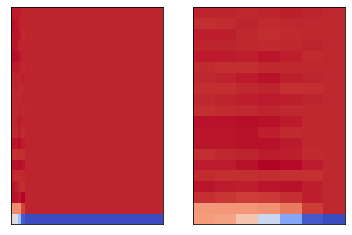

In [174]:
import librosa
import librosa.display

#Loading audio files
y1, sr1 = librosa.load(listeFichiersAUDIO[17]) 
y2, sr2 = librosa.load(listeFichiersAUDIO[18]) 

#Showing multiple plots using subplot
plt.subplot(1, 2, 1) 
mfcc1 = librosa.feature.mfcc(y1,sr1)   #Computing MFCC values
librosa.display.specshow(mfcc1)

plt.subplot(1, 2, 2)
mfcc2 = librosa.feature.mfcc(y2, sr2)
librosa.display.specshow(mfcc2)

from numpy.linalg import norm
dist, cost, acc_cost, path = dtw(mfcc1.T, mfcc2.T, dist=lambda x, y: norm(x - y, ord=1))
print('Normalized distance between the two sounds:', dist,path )  # 0 for similar audios 

(-0.5, 6.5)

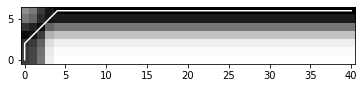

In [177]:
plt.imshow(cost.T, origin='lower', cmap=cm.gray, interpolation='nearest')
plot(path[0], path[1], 'w') #creating plot for DTW
xlim((-0.5, cost.shape[0]-0.5))
ylim((-0.5, cost.shape[1]-0.5))